In [1]:
# %load_ext autoreload
# %autoreload 2
# %reload_ext autoreload
import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../lib'))

import config
from write_audio import write_audio_for_df
from evaluate import get_results

from sklearn.utils import shuffle
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd


C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


# General use instructions
This code is complementary to the paper: HumBugDB: a large-scale acoustic mosquito dataset. Section B of `/docs/` gives detail on the meaning of the metadata fields that are present in the `csv` file `config.data_df`, while Section C describes in more detail the models used here as baselines.


This notebook provides the interface to partition data, extract features, train a BNN model in either PyTorch or Keras and evaluate its accuracy, precision-recall, confusion matrices and uncertainty metrics. Settings are specified in `config.py` and `config_pytorch.py` or `config_keras.py` which are located in `../lib`. Functions are imported from data and feature processing code in `../lib/feat_util.py`, model training in `../lib/runTorch.py` or `../lib/runKeras.py` and evaluation in `../lib/evaluate.py`.

### Data configuration `config.py`
Specify the metadata (csv) location in `data_df`, with the location of the raw wave files in `data_dir`. The desired output for the features is set by `dir_out`. Model objects will be saved to `../models/PyTorch/`.

The feature extraction uses log-mel features with `librosa`, configurable in `config.py` with the sample rate `rate`, to which data is re-sampled on loading, a window size `win_size` which determines the size of a training window (in number of _feature_ windows), `step_size`, which determines the step size taken by the window, `NFFT`, and `n_hop`, which are parameters for the core STFT transform upon which log-mel feature extraction is based. Finally, `n_feat` determines the number of mel-frequency bands.

In `librosa`, we can calculate the value of `win_size` to achieve a user's desired `duration` for a label as follows:

`win_size` = `duration` / `frame_duration`, where `frame_duration` = `n_hop`/`rate`. Librosa uses a default `hop_length` of `NFFT/4`.
The default values in `config.py` are optimised for `rate` = 8000 with  `win_size` = 30, `NFFT` = 2048, `n_hop` = `default`,  to achieve a label duration of $30 \times 2048/(4\times 8000) = 1.92$ (s). A discussion on feature transformations is given in Section B of the docs.

### PyTorch `config_pytorch.py`
`config_pytorch.py` incldues settings to change the learning rate, `lr`, the number of maximum overrun steps for a particular training criteria `max_overrun`, the number of `epochs`, and the `batch_size`. The type of training method used can be written in `train_model.py`, which by default supports saving the best epoch models for either the training accuracy, `best_train_acc`, or validation accuracy, `best_val_acc`, if supplied to `train_model`.

### Keras `config_keras.py`
`tau = 1.0`,`lengthscale = 0.01`, are parameters used for $l2$ weight regularization supplied in lines 35-37 of `runKeras.py`. `dropout = 0.2` controls the dropout rate,`validation_split = 0.2`, is the fraction of data supplied as validation to the model callbacks in `model.fit`, line 105. `batch_size` controls the batch size, and `epochs`, set the number of epochs to train. Note the slight difference between the two packages in the way validation data is passed to the model training.

## Step 1: Choose Keras or PyTorch

In [3]:
library = 'Keras'

if library == 'PyTorch':
    from PyTorch.runTorch import (train_model, load_model, evaluate_model, evaluate_model_aggregated, VGGishDropout,
    Resnet50DropoutFull, Resnet18DropoutFull, VGGishDropoutFeatB)
elif library == 'Keras':
    from tensorflow import keras
    from Keras.runKeras import train_model, load_model, evaluate_model
else:
    print('Library:', library, 'not supported. Please add your own code for support of that framework.')

C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ikiskin

## Step 2a: Data partitioning for feature extraction
Feel free to adjust the training data according to any criteria available from the metadata of the labels, which are stored in `config.data_df`. The code here imports all data that is not in testing to the training set (which can then be further split into validation).
Take extra care to make sure recordings from the same experimental group, as given in Table (ref), and indicated in `df['country'], df['location_type']`. do not appear both in train and testing, resulting in overestimate of performance on evaluation. The assertion is given to perform a check to ensure no duplicates arise.

In [4]:
df = pd.read_csv(config.data_df)

# To be kept: please do not edit the test set: these paths select test set A, test set B as described in the paper
idx_test_A = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'field')
idx_test_B = np.logical_and(df['country'] == 'UK', df['location_type'] == 'culture')
idx_train = np.logical_not(np.logical_or(idx_test_A, idx_test_B))
df_test_A = df[idx_test_A]
df_test_B = df[idx_test_B]


df_train = df[idx_train]

# Modify by addition or sub-sampling of df_train here
# df_train ... 

# Assertion to check that train does NOT appear in test:
assert len(np.where(pd.concat([df_train,df_test_A,
                               df_test_B]).duplicated())[0]) == 0, 'Train dataframe contains overlap with Test A, Test B'

## Step 2b: Choose feature extraction pipeline

To use the features extracted for [VGGish](https://github.com/harritaylor/torchvggish)'s model class, import from `feat_vggish`. For all other models, extract features from `feat_util`

In [5]:
feat_type = 'FeatA'

if feat_type == 'FeatA': #VGGish features (Feat. A)
    from feat_vggish import get_train_test_from_df, get_test_from_df, reshape_feat
#     reshape_test = False  # Keep in list form to perform feature aggregation
elif feat_type == 'FeatB': #log-mel-128 win 30 step 5 train, step 30 test, features (Feat. B)
    from feat_util import get_train_test_from_df, get_test_from_df
#     reshape_test = True # Reshape to match shape requirement of train for model prediction
else:
    print('Features:', feat_type, 'not defined. Please check spelling or add your own code for support of those f.')

In [6]:
X_train, y_train, X_test_A, y_test_A, X_test_B, y_test_B = get_train_test_from_df(df_train, df_test_A, df_test_B, debug=True)

Loading training features found at: ..\outputs\features\MED\vggish_feat_train.pickle
Loading test features found at: ..\outputs\features\MED\vggish_feat_test.pickle


### Performance optimisations
When creating features from data with mixed sample rates, `librosa.load` uses re-sampling (if specified) This is a really time consuming process, which may be circumvented by re-sampling the data once and storing in a folder before feature extraction.

### Feature processing or loading
Note that these settings require at least 16 GB RAM to load into memory for ResNet-50 processing, as channels are replicated 3 times to match the pre-trained weights model (see more on StackExchange [here](https://stackoverflow.com/questions/62971655/how-can-i-change-number-of-channels-on-resnet-to-make-it-work-only-on-b-w-images)). To reduce the strain on memory, increase the `step_size` parameter in `config.py` to reduce the number of windows created by feature extraction. This reduces the overlap between samples. 

Alternatively, it is possible to use a non-pretrained architecture and change the tensor creation code in `build_dataloader()` from `runTorch.py` to remove `.repeat(1,3,1,1)` as there will be no need to copy over identical data over three channels. 

Note that once the tensors have been created, VRAM is not an issue due to the batching over the dataloaders (this code has been run on a GTX970 with 3.5GB available VRAM).

If memory issues still persist, for further debugging see [here](https://medium.com/@raghadalghonaim/memory-leakage-with-pytorch-23f15203faa4).

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Step 3: Model training

In [7]:
# for Keras, the function call is of form train_model(X_train, y_train, X_val=None, y_val=None)
model = train_model(X_train, y_train, x_val=X_val, y_val=y_val)

# for PyTorch, choose from model = [VGGishDropout(), VGGishDropoutFeatB(), Resnet50DropoutFull(),
# Resnet18DropoutFull()]. See models in runTorch.py
# model = train_model(X_train, y_train, x_val=X_val, y_val=y_val, model=Resnet18DropoutFull())

Training on cuda:0
Saving model to: ..\outputs\models\pytorch\model_e0_2021_08_25_22_11_48.pth
Epoch: 0, Train Loss: 0.14877290, Train Acc: 0.95127243, Val Loss: 0.00026857, Val Acc: 0.94237833, overrun_counter 0
Saving model to: ..\outputs\models\pytorch\model_e1_2021_08_25_22_13_57.pth
Epoch: 1, Train Loss: 0.11818017, Train Acc: 0.96139674, Val Loss: 0.00016035, Val Acc: 0.96359045, overrun_counter 0
Epoch: 2, Train Loss: 0.10873925, Train Acc: 0.96519623, Val Loss: 0.00017112, Val Acc: 0.96088154, overrun_counter 1
Epoch: 3, Train Loss: 0.10086195, Train Acc: 0.96797410, Val Loss: 0.00094570, Val Acc: 0.92920110, overrun_counter 2
Saving model to: ..\outputs\models\pytorch\model_e4_2021_08_25_22_20_19.pth
Epoch: 4, Train Loss: 0.09744121, Train Acc: 0.96888093, Val Loss: 0.00013007, Val Acc: 0.97222222, overrun_counter 0
Epoch: 5, Train Loss: 0.09123600, Train Acc: 0.97080937, Val Loss: 0.00014832, Val Acc: 0.96671258, overrun_counter 1
Epoch: 6, Train Loss: 0.08783250, Train Acc: 

## Step 4: Model evaluation

In [5]:
# Optional: laod test data and model only to avoid committing X_train to memory
# X_test_A, y_test_A, X_test_B, y_test_B = get_test_from_df(df_test_A, df_test_B, pickle_name='vggish_feat_test_for_resize.pickle', debug=True)
X_test_A, y_test_A, X_test_B, y_test_B = get_test_from_df(df_test_A, df_test_B)

Loading test features found at: ..\outputs\features\MED\log_mel_feat_test_128_win_30_step_30_norm_True.pickle


In [11]:
# PyTorch:
full_path = '../outputs/models/pytorch/'
# model_name = 'neurips_2021_humbugdb_resnet50_bnn.pth'
# model = load_model(full_path + model_name, model=Resnet50DropoutFull())
# Keras:
# full_path = '../outputs/models/keras/'
# model_name = 'neurips_2021_humbugdb_keras_bnn_best.hdf5'

# Keras... VGGish???
full_path = '../outputs/models/keras/'
model_name= 'Win_30_Stride_5_2021_08_07_14_04_31-e60val_accuracy0.9652.hdf5'
model = load_model(full_path + model_name)
                   
# #VGGish:
# full_path = '../outputs/models/pytorch/'
# model_name = 'model_e11_2021_08_04_00_45_31.pth'
# # model_name = 'model_e0_2021_08_05_10_23_38.pth'

# # ResNet50 Vggish

# model_name = 'model_e17_2021_08_07_03_48_34.pth'


# # #ResNet18 VGGish
# # model_name = 'model_e24_2021_08_07_13_16_10.pth'
# model_name = 'model_e10_2021_08_25_22_32_56.pth' # paper verison currently

# model_name = 'model_e4_2021_08_25_22_20_19.pth' # Updated paper version
# model = load_model(full_path + model_name)


In [23]:
full_path = '../outputs/models/pytorch/'
model_name = 'model_e1_2021_08_25_00_47_14.pth' # more biased towards true positives
model_name = 'model_e0_2021_08_25_09_04_10.pth' # Similar to resnet18 (epoch 0)
model = load_model(full_path+model_name, model=Resnet50DropoutFull())

Training on cuda:0


In [11]:
full_path = '../outputs/models/pytorch/'
model_name = 'model_e10_2021_08_24_01_21_38.pth' 
model = load_model(full_path + model_name, model=VGGishDropout())


Training on cuda:0


Generate BNN samples. Run with `n_samples` = 1 for deterministic NN, `n` >= 10 for BNN. Calculate the predictive entropy (PE), mutual information (MI), and log probabilities. Also plot the ROC curve and confusion matrix.

### Test A evaluation

F:\PostdocCode\HumBugDB\lib\evaluate.py:23: RuntimeWarning: divide by zero encountered in log
  G_X, U_X, log_prob = active_BALD(np.log(out), y_test, 2)


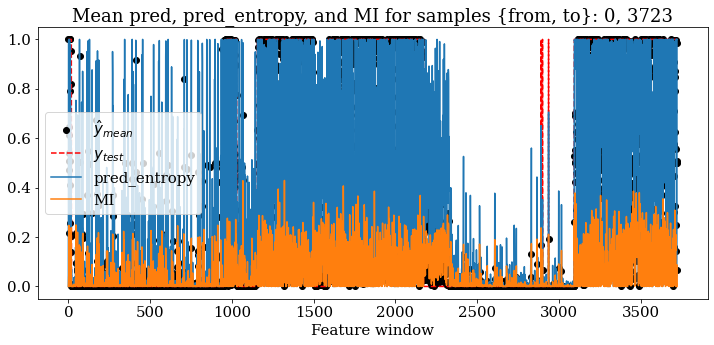

mean ROC AUC: 0.9810660505902508
std ROC AUC: 0.0016573604627448536
Confusion matrix, as input by user
[[98.1906  1.8094]
 [20.6059 79.3941]]


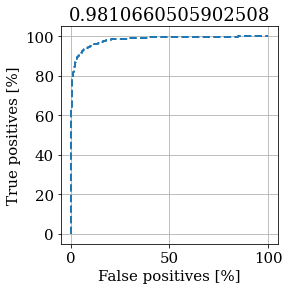

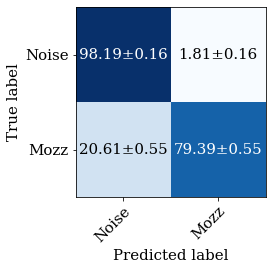

In [47]:
if feat_type == 'FeatA':
    p, yt = evaluate_model_aggregated(model, X_test_A, y_test_A, 30)  # Aggregate windows from feature list (0.96->1.92 s)
    PE, MI, log_prob = get_results(p, yt, filename = feat_type + '_' + model_name +'_Test_A_repro')
elif feat_type == 'FeatB':
    y_preds_all = evaluate_model(model, X_test_A, y_test_A, 30)  # Predict directly over feature windows (1.92 s)
    PE, MI, log_prob = get_results(y_preds_all, y_test_A, filename = feat_type + '_' + model_name +'_Test_A')

### Test B evaluation

F:\PostdocCode\HumBugDB\lib\evaluate.py:23: RuntimeWarning: divide by zero encountered in log
  G_X, U_X, log_prob = active_BALD(np.log(out), y_test, 2)


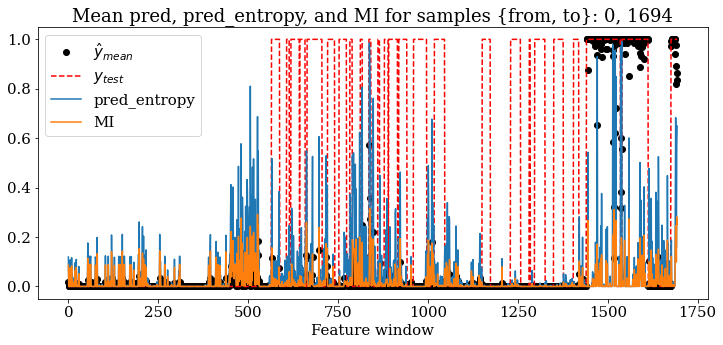

mean ROC AUC: 0.6819692961474557
std ROC AUC: 0.004028774804149416
Confusion matrix, as input by user
[[99.6978  0.3022]
 [69.9076 30.0924]]


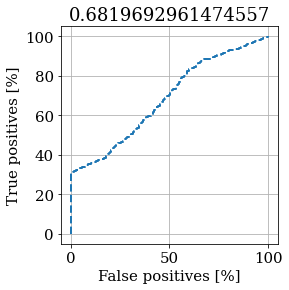

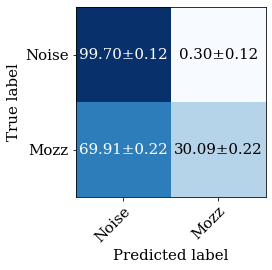

In [48]:
if feat_type == 'FeatA':
    p, yt = evaluate_model_aggregated(model, X_test_B, y_test_B, 30)  # Aggregate windows from feature list (0.96->1.92 s)
    PE, MI, log_prob = get_results(p, yt, filename = feat_type + '_' + model_name +'_Test_B_repro')
elif feat_type == 'FeatB':
    y_preds_all = evaluate_model(model, X_test_B, y_test_B, 30)  # Predict directly over feature windows (1.92 s)
    PE, MI, log_prob = get_results(y_preds_all, y_test_B, filename = feat_type + '_' + model_name +'_Test_B')
    

F:\PostdocCode\HumBugDB\lib\evaluate.py:20: RuntimeWarning: divide by zero encountered in log
  G_X, U_X, log_prob = active_BALD(np.log(out), y_test, 2)


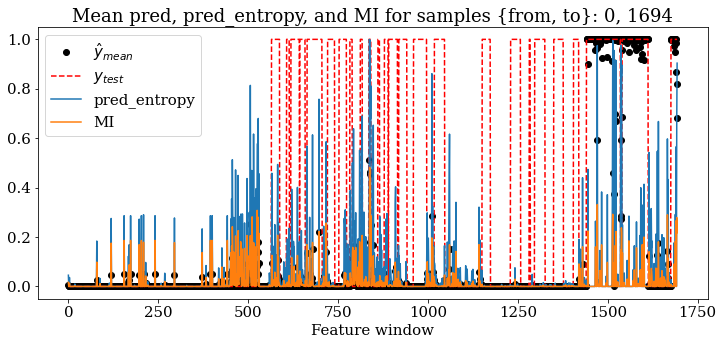

mean ROC AUC: 0.7101816486154895
std ROC AUC: 0.002316639382912941
Confusion matrix, as input by user
[[99.7317  0.2683]
 [69.9511 30.0489]]


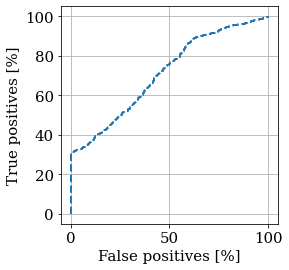

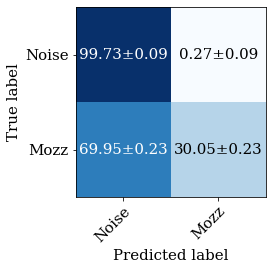

In [43]:
PE, MI, log_prob = get_results(p, yt, filename = 'BNNKerasVGGish'+ model_name +'_Test_B')

F:\PostdocCode\HumBugDB\lib\evaluate.py:20: RuntimeWarning: divide by zero encountered in log
  G_X, U_X, log_prob = active_BALD(np.log(out), y_test, 2)


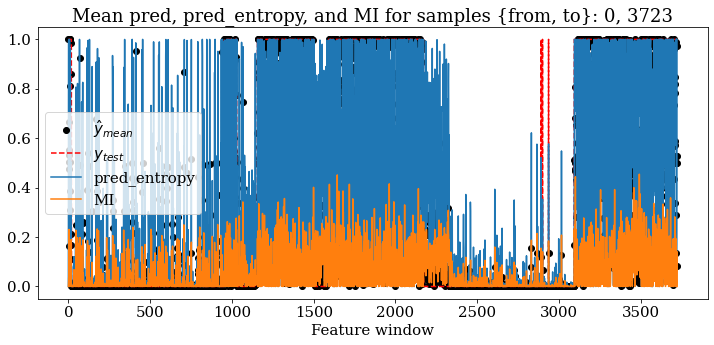

mean ROC AUC: 0.9806748677749497
std ROC AUC: 0.0020259208959221685
Confusion matrix, as input by user
[[98.3051  1.6949]
 [20.5475 79.4525]]


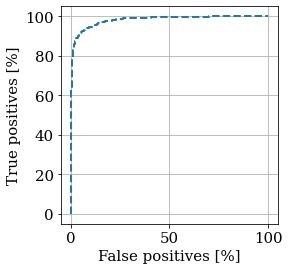

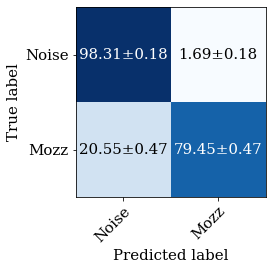

In [46]:
p,yt = resize_window(model, X_test_A, y_test_A, 30)
PE, MI, log_prob = get_results(p, yt, filename = 'KerasVGGish'+ model_name +'_Test_A')